**Note**: The code gets very confused and returns weird-looking results if the wave pattern is not as expected.

The easiest way to rectify this may be to solve the Riemann problem for a particular rho_L and vt_L = 0, identify the potential transitions then tailor the solver to these.

In [2]:
from r3d2 import State, eos_defns
import numpy
numpy.seterr(invalid='raise')
from scipy.optimize import brentq
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = (10, 8)
plt.rc("font", size=25)

In [3]:
gamma = 5/3
eos = eos_defns.eos_gamma_law(gamma)
# rho, v, vt, eps, eos
q_right = State(8.0, -0.2, 0.1, 2.5, eos)

#rhoL = 5.0
vL = 0.0
epsL = 2.0

In [4]:
def find_crit_vt(vt_L, q_L, q_R, lr_sign=-1):
    """
    Returns vx_L* - vx_R, which should be 0 at the tangential velocity.
    """
    
    # Re-construct state with new vt_L - this is better than just setting q_L.vt = vt_L as
    # it ensures that all member variables (eg. W_lorentz) are recalculated with new vt.
    q_L = State(q_L.rho, q_L.v, vt_L, q_L.eps, q_L.eos)
    
    def find_eps_star(eps_star):
        rho_star = eos['rho_from_p_eps'](q_R.p, eps_star)
        h_star = eos['h_from_rho_eps'](rho_star, eps_star)
        
        return h_star**2 - q_L.h**2 - (h_star/rho_star + q_L.h/q_L.rho) * (q_R.p - q_L.p)
     
    eps_min = min(q_R.eps, q_L.eps) * 0.9
    eps_max = max(q_R.eps, q_L.eps) * 1.1
    
    max_iter = 1000
    i = 0
    
    while find_eps_star(eps_min) * find_eps_star(eps_max) > 0.0 and i < max_iter:
        i += 1
        eps_min /= 5.0
        eps_max *= 5.0
        
    if find_eps_star(eps_min) * find_eps_star(eps_max) > 0.0:
        raise StopIteration('Reached max_iter')
    
    eps_star = brentq(find_eps_star, eps_min, eps_max)
    
    rho_star = eos['rho_from_p_eps'](q_R.p, eps_star)
    h_star = eos['h_from_rho_eps'](rho_star, eps_star)
    
    # mass flux 
    j2 = (q_L.p - q_R.p) / ((q_L.h**2 - h_star**2) / (q_L.p - q_R.p) - 2. * q_L.h / q_L.rho)
    
    V_minus = (q_L.rho**2 * q_L.W_lorentz**2 * q_L.v + lr_sign * j2 * 
               numpy.sqrt(1. + q_L.rho**2 * q_L.W_lorentz**2 * (1. - q_L.v**2)/j2)) / \
              (q_L.rho**2 * q_L.W_lorentz**2 + j2)
        
        
    # now use the fact that vx_L* = vx_R, p_L* = p_R to root find 
    
    return (q_L.h * q_L.W_lorentz * q_L.v + lr_sign * (q_R.p - q_L.p) / (numpy.sqrt(j2*(1. - V_minus**2)))) / \
           (q_L.h * q_L.W_lorentz + (q_R.p - q_L.p) * 
                (1. / (q_L.rho * q_L.W_lorentz) + lr_sign * q_L.v / numpy.sqrt(j2 * (1. - V_minus**2)))) - q_R.v
    

In [5]:
rhoLs = numpy.linspace(0.2,8., num=50000)

min_vt = 0.1
max_vt = 0.9999

vts = []

for rho in rhoLs:
    try:
        q_left = State(rho, vL, 0.0, epsL, eos)
        crit_vt = brentq(find_crit_vt, min_vt, max_vt, args=(q_left, q_right))
    except ValueError:
        # at this point, the left density is high enough that we begin with a detonation so no transition
        break
    vts.append(crit_vt)

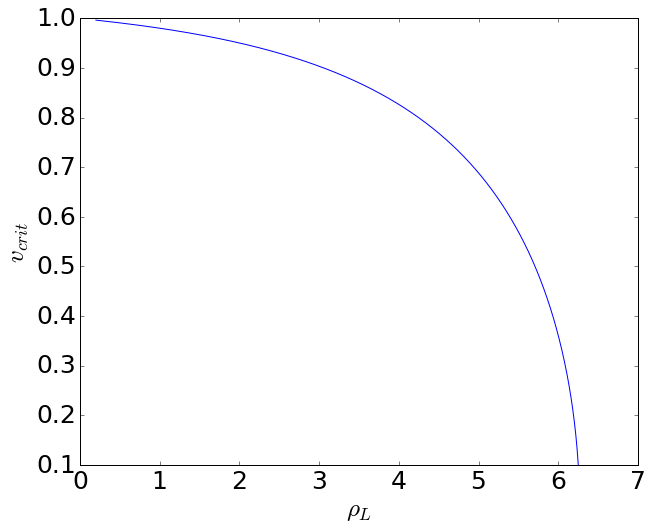

In [6]:
plt.plot(rhoLs[:len(vts)], vts)
plt.xlabel(r'$\rho_L$')
plt.ylabel(r'$v_{crit}$')

to_save = False

outfile = "../Writing/figures/vt_crit"
if to_save:
    plt.savefig(outfile)

plt.show()

In [7]:
# The point where the code blew up should give a good estimate of the value of rho_L when v_crit = 0
rhoLs[len(vts)-1]

6.2508930178603572

In [8]:
# rho, v, vt, eps, eos

eos_reactive = eos_defns.eos_gamma_law_react(5.0/3.0, 0.1, 1.0, 1.0, eos)
#U_reactive = State(5.0, 0.0, vt, 2.1, eos_reactive)
#U_burnt = State(0.5, 0.5, 0.0, 2.0, eos)
U_burnt = State(8, -0.2, 0.1, 2.5, eos)

rhoLs = numpy.linspace(12.,0.1, num=500)

min_vt = 0.1
max_vt = 0.9999

vts = []

for rho in rhoLs:
    try:
        q_left = State(rho, 0.0, 0.0, 2.0, eos_reactive)
        crit_vt = brentq(find_crit_vt, min_vt, max_vt, args=(q_left, U_burnt))
    except (ValueError, FloatingPointError):
        # at this point, the left density is high enough that we begin with a detonation so no transition
        try:
            crit_vt = brentq(find_crit_vt_det, min_vt, max_vt, args=(q_left, U_burnt))
        except Exception:
            crit_vt = numpy.nan
    vts.append(crit_vt)
    
    

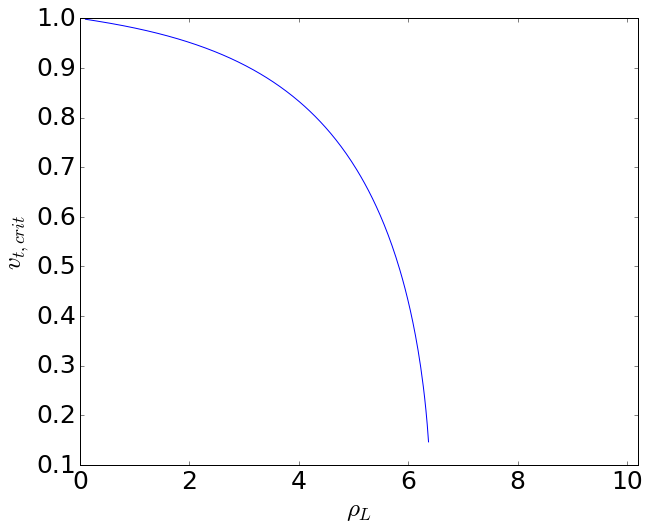

In [9]:
plt.plot(rhoLs[:len(vts)], vts)
plt.xlabel(r'$\rho_L$')
plt.ylabel(r'$v_{t,crit}$')
plt.ylim([0.1, None])
plt.xlim([0., 10.2])

to_save = False

outfile = "../Writing/figures/vt_crit"
if to_save:
    plt.savefig(outfile)

plt.show()

In [10]:
from r3d2.wave import Wave, Detonation, Deflagration

In [11]:
def find_crit_vt_det(vt_l, q_l, q_r, lr_sign=-1):
    """
    It's nowhere near as simple to calculate the weak -> strong det transition. Shall instead hack the riemann solver code
    """
    
    q_l = State(q_l.rho, q_l.v, vt_l, q_l.eps, q_l.eos)
    
    
    def find_delta_v(p_star_guess):

        wave_l = Wave(q_l, p_star_guess, 0)
        wave_r = Wave(q_r, p_star_guess, 2)

        return wave_l.q_r.v - wave_r.q_l.v

    pmin = min(q_l.p, q_r.p)
    pmax = max(q_l.p, q_r.p)
    while find_delta_v(pmin) * find_delta_v(pmax) > 0.0:
        pmin /= 2.0
        pmax *= 2.0

    pmin_rootfind = 0.9 * pmin
    pmax_rootfind = 1.1 * pmax
    try:
        find_delta_v(pmin_rootfind)
    except ValueError:
        pmin_rootfind = pmin
    try:
        find_delta_v(pmax_rootfind)
    except ValueError:
        pmax_rootfind = pmax

    p_star = brentq(find_delta_v, pmin_rootfind, pmax_rootfind)
    
    #print('q_l.p, p_star: {},{}'.format(q_l.p, p_star))
    
    # NOTE: Have assumed the burning wave is the first one
    wave_l = Wave(q_l, p_star, 0)
    
    detonation = Detonation(q_l, p_star, 0)
    
    #print('detonation.q_end.p, p_star: {},{}'.format(detonation.q_end.p, p_star))
    
    if numpy.isclose(detonation.q_end.p, p_star, rtol=1.e-8):
        return -p_star
    else:
        return detonation.q_end.p - p_star


In [12]:
def find_crit_vt_detdefl(vt_l, q_l, q_r, lr_sign=-1):
    """
    It's nowhere near as simple to calculate the weak -> strong det transition. Shall instead hack the riemann solver code
    """
    
    q_l = State(q_l.rho, q_l.v, vt_l, q_l.eps, q_l.eos)
    
    
    def find_delta_v(p_star_guess):

        wave_l = Wave(q_l, p_star_guess, 0)
        wave_r = Wave(q_r, p_star_guess, 2)

        return wave_l.q_r.v - wave_r.q_l.v

    pmin = min(q_l.p, q_r.p)
    pmax = max(q_l.p, q_r.p)
    while find_delta_v(pmin) * find_delta_v(pmax) > 0.0:
        pmin /= 2.0
        pmax *= 2.0

    pmin_rootfind = 0.9 * pmin
    pmax_rootfind = 1.1 * pmax
    try:
        find_delta_v(pmin_rootfind)
    except ValueError:
        pmin_rootfind = pmin
    try:
        find_delta_v(pmax_rootfind)
    except ValueError:
        pmax_rootfind = pmax

    p_star = brentq(find_delta_v, pmin_rootfind, pmax_rootfind)
    
    #print('q_l.p, p_star: {},{}'.format(q_l.p, p_star))
    
    # NOTE: Have assumed the burning wave is the first one
    wave_l = Wave(q_l, p_star, 0)
    
    if q_l.p < p_star:
        burning_wave = Detonation(q_l, p_star, 0)
    else:
        burning_wave = Deflagration(q_l, p_star, 0)
    
    #print('detonation.q_end.p, p_star: {},{}'.format(detonation.q_end.p, p_star))
    
    # TODO: check this works for a deflagration wave too???
    
    if numpy.isclose(burning_wave.q_end.p, p_star, rtol=1.e-8):
        return -p_star
    else:
        return burning_wave.q_end.p - p_star

In [13]:
# eos_reactive = eos_defns.eos_gamma_law_react(5.0/3.0, 0.1, 1.0, 1.0, eos)
#U_reactive = State(5.0, 0.0, vt, 2.1, eos_reactive)
test_7_U_burnt = State(0.24316548798524526, 0.39922932397353039, 0.0,
                    0.61686385086179807, eos)

rhoLs = numpy.linspace(20.,0.05, num=500)

min_vt = 0.1
max_vt = 0.9999

vts = []

for rho in rhoLs:
    #print(find_crit_vt_det(min_vt, q_left, U_burnt))
    #print(find_crit_vt_det(max_vt, q_left, U_burnt))
    try:
        q_left = State(rho, 0.0, 0.0, 1.0, eos_reactive)
        crit_vt = brentq(find_crit_vt, min_vt, max_vt, args=(q_left, U_burnt))
        #crit_vt = numpy.nan
    except (ValueError, FloatingPointError):
        # at this point, the left density is high enough that we begin with a detonation so no transition
        try:
            crit_vt = brentq(find_crit_vt_detdefl, min_vt, max_vt, args=(q_left, U_burnt))
        except Exception:
            crit_vt = numpy.nan
    vts.append(crit_vt)

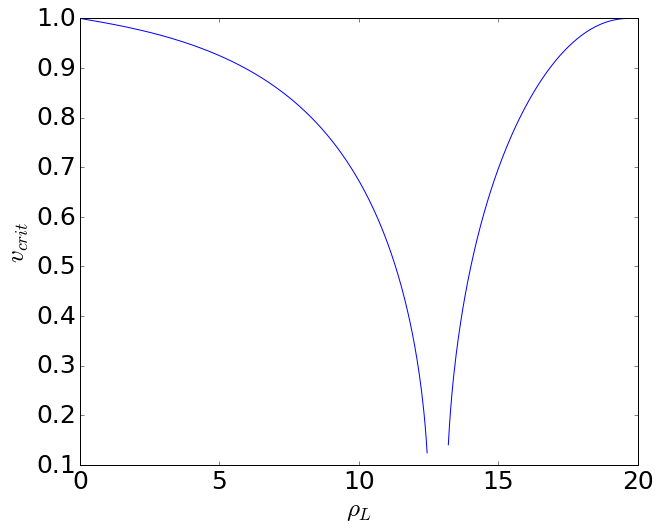

In [14]:
plt.plot(rhoLs, vts)
plt.xlabel(r'$\rho_L$')
plt.ylabel(r'$v_{crit}$')
#plt.ylim([0.1, None])

to_save = False

outfile = "../Writing/figures/vt_crit"
if to_save:
    plt.savefig(outfile)

plt.show()